In [1]:
import importlib
import sys,os,math,time

import networkx as nx
import geopandas as gpd
import numpy as np
import osmnx as ox
import pandas as pd
import rasterio
import pylab as plt
import json
import pycrs
import seaborn as sns

from shapely.geometry import 
from rasterio.plot import show, show_hist
from rasterio.mask import mask

import GOSTnet as gn
from pandana.loaders import osm;

from osgeo import gdal, gdalconst, gdal_array
from rasterstats import point_query, zonal_stats
from make_fishnet import make_fishnet

peartree version: 0.6.1 
networkx version: 2.2 
matplotlib version: 3.0.2 
osmnx version: 0.9 


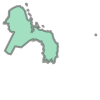

In [2]:
boundary_GDF = ox.gdf_from_place('Dar Es Salaam',which_result=2)
boundary_poly = boundary_GDF.loc[0,'geometry']    # boundary as shapely polygon
boundary_poly

In [25]:
path = 'data/Dar data for Nick'
tif_10_proj_path = os.path.join(path, 'TZ-UU-10-1.tif_clipped.tif')
tif_50_proj_path = os.path.join(path, 'TZ-UU-50-1.tif_clipped.tif')
tif_100_proj_path = os.path.join(path, 'TZ-UU-100-1.tif_clipped.tif')

raster = rasterio.open(tif_10_proj_path,nodata = -9999)
coords = (raster.bounds[1], raster.bounds[0], raster.bounds[3], raster.bounds[2])


In [86]:
ES_locations_path = os.path.join(path, 'ES_locations_Dar.shp')
ES_locations = gpd.read_file(ES_locations_path)

In [ ]:
f, ax = plt.subplots(1,figsize=[6,6])
show(raster, ax=ax)
#boundary_GDF.plot(alpha = 0.5, ax=ax, color='r')

#grid_clipped.plot(ax=ax,alpha=0.5)
#POIs_health.plot(ax=ax,color='r')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.title('Dar flood map');

In [74]:
# Create graph
G = ox.graph_from_polygon(boundary_poly, network_type = 'drive')

In [75]:
from shapely.geometry import Point
from shapely.geometry import LineString

node_dict = {}

G2 = G.copy()

for u, data in G2.nodes(data = True):
    node_dict[u] = Point(data['x'],data['y'])
        
for u, v, data in G2.edges(data = True):
    
    if 'Wkt' not in data.keys():
        strt = node_dict[u]
        fini = node_dict[v]
        data['Wkt'] = LineString([strt, fini])
    
    if 'geometry' in data.keys():
        data['Wkt'] = data['geometry']
        data.pop('geometry')

In [76]:
importlib.reload(gn)
G3 = gn.salt_long_lines(G2,
                       source = 'epsg:4326',
                      target = 'epsg:32636',
                      thresh = 50,
                      factor = 1)

peartree version: 0.6.1 
networkx version: 2.2 
matplotlib version: 3.0.2 
osmnx version: 0.9 
Identified 60635 unique edge(s) longer than 50. 
Beginning new node creation...
471058 new edges added and 120295 removed to bring total edges to 505461
174894 new nodes added to bring total nodes to 234857


In [77]:
G3 = gn.sample_raster(G3, tif_10_proj_path, property_name = 'flood_depth_10_yr')
G3 = gn.sample_raster(G3, tif_50_proj_path, property_name = 'flood_depth_50_yr')
G3 = gn.sample_raster(G3, tif_100_proj_path, property_name = 'flood_depth_100_yr')

In [109]:
for u, d in G3.nodes(data=True):
    for field in ['flood_depth_10_yr','flood_depth_50_yr','flood_depth_100_yr']:
        if d[field] <= 0:
            out_value = np.nan
        elif d[field] > 10:
            out_value = np.nan
        else:
            out_value = d[field]
        clean_field_name = field + '_clean'
        d[clean_field_name] = out_value

In [ ]:
gdf = gn.node_gdf_from_graph(G3)

In [111]:
gn.example_node(G3)

(5065801731, {'y': -6.6966536, 'x': 39.1788008, 'osmid': 5065801731, 'flood_depth_10_yr': 0.0, 'flood_depth_50_yr': 0.0, 'flood_depth_100_yr': 0.0, 'flood_10_yr_clean': nan, 'flood_depth_100_yr_clean': nan, 'flood_depth_10_yr_clean': nan, 'flood_depth_50_yr_clean': nan})


In [118]:
gdf.flood_depth_10_yr_clean.mean()

0.205895812787933

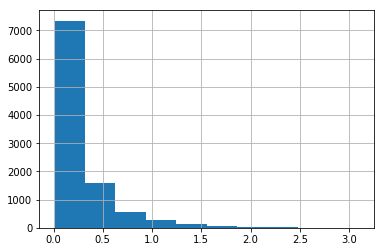

In [115]:
gdf.flood_depth_50_yr_clean.hist()

In [9]:
gn.example_node(G3)

(6241026052, {'y': 0.3487386, 'x': 32.5916098, 'osmid': 6241026052, 'flood_depth_10_yr': -32767.0, 'flood_depth_50_yr': -32767.0, 'flood_depth_100_yr': -32767.0})


#### 4. Create the degraded road networks

In [119]:
node_gdf = gn.node_gdf_from_graph(G3)
edge_gdf = gn.edge_gdf_from_graph(G3)

In [134]:
edge_gdf.highway = edge_gdf.highway.astype(str)

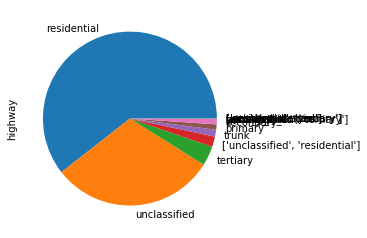

In [135]:
edge_gdf.highway.value_counts().plot(kind='pie')

In [136]:
speed_dict = {  'residential': 20,  # kmph
                'primary': 40, # kmph
                'primary_link':35,
                'motorway':45,
                'motorway_link': 40,
                'trunk': 40,
                'trunk_link':35,
                'secondary': 30, # kmph
                'secondary_link':25,
                'tertiary':25,
                'tertiary_link': 25,
                'unclassified':20, 
                'road':20,
                'crossing':20,
                'living_street':20
                }

speed_dict_flooded = { 'residential': 17, 'primary': 35, 'primary_link':31, 'motorway':40, 'motorway_link': 35, 'trunk': 35, 'trunk_link':31.5, 'secondary': 28.5, 'secondary_link':22, 'tertiary':22, 'tertiary_link': 22, 'unclassified':19, 'road':19, 'crossing':19, 'living_street':19 }

In [137]:
G3 = gn.convert_network_to_time(G3, distance_tag = 'length', speed_dict = speed_dict)

In [149]:
G_flood10 = gn.convert_network_to_time(G3.copy(), distance_tag = 'length', speed_dict = speed_dict_flooded)
G_flood50 = gn.convert_network_to_time(G3.copy(), distance_tag = 'length', speed_dict = speed_dict_flooded)
G_flood100 = gn.convert_network_to_time(G3.copy(), distance_tag = 'length', speed_dict = speed_dict_flooded)

In [140]:
gdf_50 = gn.node_gdf_from_graph(G_flood50)

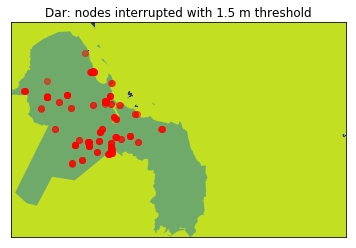

In [147]:
raster = rasterio.open(tif_50_proj_path)
ax = boundary_GDF.plot(alpha = 0.5, figsize=[6,6])
show(raster, ax = ax)
threshold=1.5

#grid_clipped.plot(ax=ax,alpha=0.5)
#POIs_health.plot(ax=ax,color='r')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.title('Dar: nodes interrupted with {} m threshold'.format(threshold));
gdf_50[gdf_50.flood_depth_50_yr>threshold].plot(figsize=[8,8],color='r',ax=ax,alpha = 0.5)

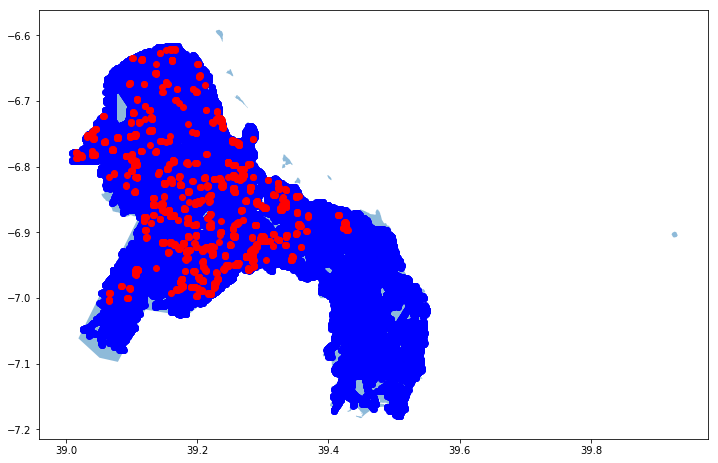

In [283]:
threshold = 0.15
ax = boundary_GDF.plot(alpha = 0.5, figsize=[12,12])
gdf_50[gdf_50.flood_depth_10_yr<threshold].plot(color='b',ax=ax)
gdf_50[gdf_50.flood_depth_10_yr>threshold].plot(color='r',ax=ax)

In [150]:
my_flood_depth = 0.15
fail_value = 999999999

print("10 year:")
G_flood10 = gn.disrupt_network(G_flood10, 'flood_depth_10_yr', my_flood_depth, fail_value)

print()
print("50 year:")
G_flood50 = gn.disrupt_network(G_flood50, 'flood_depth_50_yr', my_flood_depth, fail_value)

print()
print("100 year:")
G_flood100 = gn.disrupt_network(G_flood100, 'flood_depth_100_yr', my_flood_depth, fail_value)


10 year:
nodes disrupted: 2186
edges disrupted: 5774

50 year:
nodes disrupted: 5503
edges disrupted: 14452

100 year:
nodes disrupted: 8637
edges disrupted: 22516


In [305]:
n_nodes = node_gdf.shape[0]
n_edges = edge_gdf.shape[0]
print("Threshold {} meters:".format(my_flood_depth))
print("10-year flood disrupts {:.2f} % of nodes and {:.2f} % of edges".format (2186/n_nodes * 100, 5574/431297 * 100))
print("50-year flood disrupts {:.2f} % of nodes and {:.2f} % of edges".format (5503/n_nodes * 100, 14452/431297 * 100))
print("100-year flood disrupts {:.2f} % of nodes and {:.2f} % of edges".format (8637/n_nodes * 100, 22516/431297 * 100))

Threshold 0.15 meters:
10-year flood disrupts 0.93 % of nodes and 1.29 % of edges
50-year flood disrupts 2.34 % of nodes and 3.35 % of edges
100-year flood disrupts 3.68 % of nodes and 5.22 % of edges


In [285]:
edge_gdf2 = edge_gdf.copy()
edge_gdf2.columns

Index(['stnode', 'endnode', 'Wkt', 'highway', 'tunnel', 'junction', 'name',
       'access', 'width', 'maxspeed', 'bridge', 'oneway', 'lanes', 'ref',
       'osmid', 'length', 'geometry'],
      dtype='object')

In [288]:
edge_gdf2['centroid'] = edge_gdf2.geometry.centroid

In [297]:
x_vals = [n.x for n in edge_gdf2['centroid']]

In [298]:
edge_gdf2['x'] = x_vals

In [302]:
edge_gdf2 = edge_gdf2[edge_gdf2['x'] < 39.4]

In [306]:
print('number of applicable edges in network',edge_gdf2.shape[0])

number of applicable edges in network 431297


#### 6. Get origin points
* fishnet of the city
* sample of 307 firms from the employment survey

In [152]:
make_fishnet('grid_DS.shp',coords[1], coords[3], coords[0], coords[2],500,500) # takes xmin, xmax, ymin, ymax

In [160]:
grid=gpd.read_file('grid_DS.shp')

Text(0.5, 1.0, 'Employment survey locations')

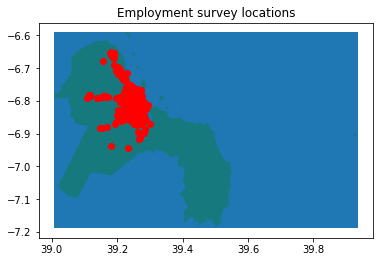

In [165]:
f, ax = plt.subplots()
grid.plot(ax = ax)
boundary_GDF.plot(ax = ax, color = 'g', alpha = 0.3)
ES_locations.plot(ax = ax, color = 'r')
plt.title('Employment survey locations')

#### 7. Get destinations (POIs and employment density)

In [81]:
# Hospitals

In [163]:
bbox = raster.bounds

amenities_hospital = ['hospital']
POIs_health = osm.node_query(bbox[1],bbox[0],bbox[3],bbox[2],tags = '"amenity"~"{}"'.format('|'.join(amenities_hospital)))

POIs_health = POIs_health[['amenity','name','lat','lon']]
POIs_health = gpd.GeoDataFrame(POIs_health)
POIs_health['geometry'] = (list(zip(POIs_health.lon,POIs_health.lat)))
POIs_health['geometry'] = POIs_health.geometry.apply(lambda x: Point(x))

POIs_health = gpd.sjoin(POIs_health,boundary_GDF,how='inner')

/anaconda3/envs/geo5/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


Text(0.5, 1.0, 'Hospitals')

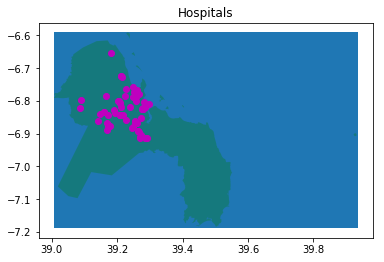

In [166]:
f, ax = plt.subplots()
grid.plot(ax = ax)
boundary_GDF.plot(ax = ax, color = 'g', alpha = 0.3)
POIs_health.plot(ax = ax, color = 'm')
plt.title('Hospitals')

#### 9. Snap Os and Ds to graph

In [170]:
grid['geometry'] = grid.centroid
grid.set_geometry('geometry',inplace=True)

In [168]:
grid = gn.pandana_snap(G3, grid)

/Users/nicholasjones/Desktop/code/network_analysis/GOSTnet.py:1572: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  G_tree = spatial.KDTree(node_gdf[['x','y']].as_matrix())
/Users/nicholasjones/Desktop/code/network_analysis/GOSTnet.py:1574: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indices = G_tree.query(in_df[['x','y']].as_matrix())


In [181]:
ES_locations = gpd.GeoDataFrame(ES_locations)
ES_locations['geometry'] = (list(zip(ES_locations.lon,ES_locations.lat)))
ES_locations['geometry'] = ES_locations.geometry.apply(lambda x: Point(x))

In [182]:
# Origins
ES_locations = gn.pandana_snap(G3, ES_locations)
grid = gn.pandana_snap(G3, grid)

# Destinations
POIs_health = gn.pandana_snap(G3, POIs_health)


/Users/nicholasjones/Desktop/code/network_analysis/GOSTnet.py:1572: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  G_tree = spatial.KDTree(node_gdf[['x','y']].as_matrix())
/Users/nicholasjones/Desktop/code/network_analysis/GOSTnet.py:1574: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indices = G_tree.query(in_df[['x','y']].as_matrix())


In [185]:
list_of_nearest_nodes_ES = list(ES_locations.NN)
list_of_nearest_nodes_grid = list(grid.NN)
list_of_nearest_nodes_POIs_health = list(POIs_health.NN)

## ANALYSIS

#### 10. Firm connectivity: travel time between ES points

In [186]:
baseline_OD_firms = gn.calculate_OD(G3, list(ES_locations.NN), list(ES_locations.NN), fail_value, weight='time')

In [187]:
flood_OD_firms_10yr = gn.calculate_OD(G_flood10, list(ES_locations.NN), list(ES_locations.NN), fail_value, weight='time')
flood_OD_firms_50yr = gn.calculate_OD(G_flood50, list(ES_locations.NN), list(ES_locations.NN), fail_value, weight='time')
flood_OD_firms_100yr = gn.calculate_OD(G_flood100, list(ES_locations.NN), list(ES_locations.NN), fail_value, weight='time')

In [188]:
travel_times_base = baseline_OD_firms[baseline_OD_firms < fail_value] / 60
travel_times_10 = flood_OD_firms_10yr[flood_OD_firms_10yr < fail_value] / 60
travel_times_50 = flood_OD_firms_50yr[flood_OD_firms_50yr < fail_value] / 60
travel_times_100 = flood_OD_firms_100yr[flood_OD_firms_100yr < fail_value] / 60

In [189]:
pd.Series(flood_OD_firms_10yr.ravel()).shape

(145924,)

In [190]:
travel_times_50.ravel().shape

(139522,)

In [191]:
gn.example_edge(G3)

(5065801731, '5065801731_1_0', {'Wkt': <shapely.geometry.linestring.LineString object at 0x1a1f2e0d68>, 'osmid': 510590059, 'length': 49, 'highway': 'unclassified', 'time': 8.82, 'mode': 'drive'})


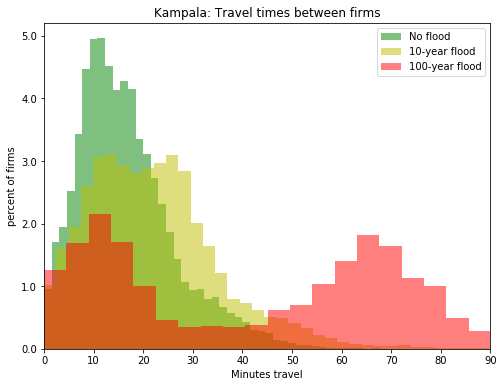

In [197]:
# Histogram of post-flood travel times between firms
bins = 50

fig,ax = plt.subplots(figsize=[8,6])
ax.hist(travel_times_base,color='g',alpha=0.5,density=True,bins=bins)
ax.hist(travel_times_10,color='y',alpha=0.5,density=True,bins=bins)
#ax.hist(travel_times_50,color='',alpha=0.5,density=True,bins=100)
ax.hist(travel_times_100,color='r',alpha=0.5,density=True,bins=bins)
plt.title('Kampala: Travel times between firms')
plt.ylabel('percent of firms')
plt.legend(['No flood','10-year flood','100-year flood'])
plt.xlabel('Minutes travel');

plt.xlim(0,90)

ticks = ax.get_yticks()*100
ticks = [round(n,1) for n in (list(ticks))]
ax.set_yticklabels(ticks);

In [268]:
pd.Series(travel_times_base).describe()

count    145924.000000
mean         16.616543
std           9.787210
min           0.000000
25%           9.609124
50%          14.965494
75%          21.677377
max          76.856949
dtype: float64

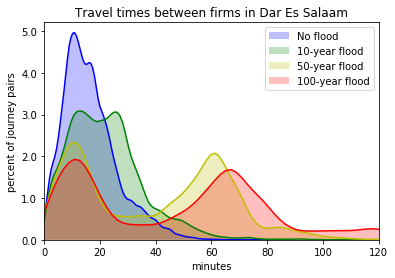

In [229]:
bw = 'scott'
fig,ax = plt.subplots(figsize=[6,4])

sns.kdeplot(travel_times_base,ax = ax, color = 'b', shade=True,bw=bw)
sns.kdeplot(travel_times_10, ax=ax, color='g',shade=True,bw=bw)
sns.kdeplot(travel_times_50, ax=ax, color='y',shade=True)
sns.kdeplot(travel_times_100, ax=ax, color='r',shade=True,bw=bw)

ax.set_title('Travel times between firms in Dar Es Salaam')
plt.legend(['No flood','10-year flood','50-year flood','100-year flood'])
ax.set(xlabel="minutes", ylabel='percent of journey pairs');
plt.xlim(0,120)

ticks = ax.get_yticks()*100
ticks = [round(n,1) for n in (list(ticks))]
ax.set_yticklabels(ticks);

In [230]:
fig.savefig('travel_time_Dar.png')
! ls

ESRI_pop_health.ipynb          flooding5_pop-health.ipynb
ESRI_pop_health_2.ipynb        flooding6.ipynb
GOSTNets                       flooding7.ipynb
GOSTnet.py                     flooding8.ipynb
README.md                      flooding9_simplify-Copy1.ipynb
SampleData                     grid_.dbf
UB_2.ipynb                     grid_.shp
UB_grid                        grid_.shx
UB_grid.csv                    grid_DS.dbf
UB_grid_csv                    grid_DS.shp
Untitled.ipynb                 grid_DS.shx
__pycache__                    grid_KM.dbf
aal_calc_3.ipynb               grid_KM.shp
accessibility_UB2.ipynb        grid_KM.shx
cache                          images
city_workflow.ipynb            logs
city_workflow_2.ipynb          make_boundary_shapes.ipynb
city_workflow_3.ipynb          make_fishnet.py
data                           pois_business.csv
flooding10.ipynb               pois_res.csv
flooding11_walking.ipynb       radar_square_mile.ipynb
flooding12_Dar.ipynb           

In [199]:
baseline_mean = travel_times_base.mean()
flood_10_mean = travel_times_10.mean()
flood_50_mean = travel_times_50.mean()
flood_100_mean = travel_times_100.mean()


In [200]:
change_df = pd.DataFrame({"mean times":[baseline_mean, flood_10_mean, flood_100_mean]},index=
                        ['no flood','10-year flood','100-year flood'])

In [201]:
change_df['percent difference'] = (change_df['mean times'] - change_df['mean times'][0]) / change_df['mean times'][0] * 100
change_df

,mean times,percent difference
no flood,16.616543,0.000000
10-year flood,22.221130,33.728957
100-year flood,49.266940,196.493323


In [202]:
change_df = pd.DataFrame({"mean times":[baseline_mean, flood_10_mean, flood_100_mean]},index=
                        ['no flood','10-year flood','100-year flood'])

In [203]:
change_df['percent difference'] = (change_df['mean times'] - change_df['mean times'][0]) / change_df['mean times'][0] * 100
change_df

,mean times,percent difference
no flood,16.616543,0.000000
10-year flood,22.221130,33.728957
100-year flood,49.266940,196.493323


In [204]:
baseline_OD_firms_DF = pd.DataFrame(baseline_OD_firms)
flood_OD_firms_10yr_df = pd.DataFrame(flood_OD_firms_10yr)
flood_OD_firms_50yr_df = pd.DataFrame(flood_OD_firms_50yr)
flood_OD_firms_100yr_df = pd.DataFrame(flood_OD_firms_100yr)

In [205]:
baseline_mean = baseline_OD_firms_DF.mean(axis=1)
flood_10yr_mean = flood_OD_firms_10yr_df[flood_OD_firms_10yr_df < 999999].mean(axis=1)
flood_50yr_mean = flood_OD_firms_50yr_df[flood_OD_firms_50yr_df < 999999].mean(axis=1)
flood_100yr_mean = flood_OD_firms_100yr_df[flood_OD_firms_100yr_df < 999999].mean(axis=1)


In [206]:
mean_times_by_firm = pd.DataFrame({'baseline_mean' : baseline_OD_firms_DF.mean(axis=1),
                                  'flood_10yr_mean' : flood_OD_firms_10yr_df[flood_OD_firms_10yr_df < 999999].mean(axis=1),
                                  'flood_50yr_mean' : flood_OD_firms_50yr_df[flood_OD_firms_50yr_df < 999999].mean(axis=1),
                                  'flood_100yr_mean' : flood_OD_firms_100yr_df[flood_OD_firms_100yr_df < 999999].mean(axis=1)})

In [207]:
def percent_change(changed, original):
    return (changed - original)/original * 100

mean_times_by_firm['diff_10'] = percent_change(mean_times_by_firm.flood_10yr_mean, mean_times_by_firm.baseline_mean)
mean_times_by_firm['diff_50'] = percent_change(mean_times_by_firm.flood_50yr_mean, mean_times_by_firm.baseline_mean)
mean_times_by_firm['diff_100'] = percent_change(mean_times_by_firm.flood_100yr_mean, mean_times_by_firm.baseline_mean)

In [208]:
mean_times_by_firm.head()

,baseline_mean,flood_10yr_mean,flood_50yr_mean,flood_100yr_mean,diff_10,diff_50,diff_100
0,838.175203,1090.068320,2455.411341,3010.892619,30.052561,192.947266,259.219959
1,796.514470,1150.778659,2423.585357,2826.511082,44.476805,204.273864,254.859979
2,898.465262,1236.398931,2076.490985,2462.601700,37.612324,131.115333,174.089807
3,840.047236,1092.002152,2456.003278,3093.943519,29.992946,192.364902,268.305898
4,1603.810876,1949.009800,4597.780572,5735.319913,21.523668,186.678476,257.605750


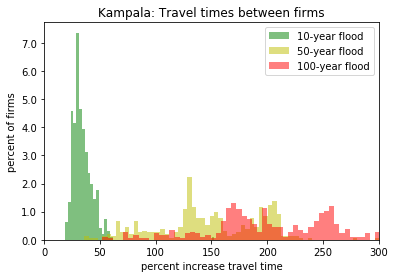

In [209]:
# Histogram of post-flood travel times between firms
bins = 100

fig,ax = plt.subplots(figsize=[6,4])
ax.hist(mean_times_by_firm.diff_10,color='g',alpha=0.5,density=True,bins=bins)
ax.hist(mean_times_by_firm.diff_50,color='y',alpha=0.5,density=True,bins=bins)
ax.hist(mean_times_by_firm.diff_100,color='r',alpha=0.5,density=True,bins=bins)
plt.title('Kampala: Travel times between firms')
plt.ylabel('percent of firms')
plt.legend(['10-year flood','50-year flood','100-year flood'])
plt.xlabel('percent increase travel time');

plt.xlim(0,300)

ticks = ax.get_yticks()*100
ticks = [round(n,1) for n in (list(ticks))]
ax.set_yticklabels(ticks);

In [237]:
mean_times_by_firm['diff_100'][mean_times_by_firm['diff_100'] == 0] = np.nan

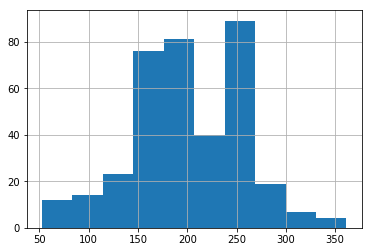

In [239]:
mean_times_by_firm['diff_100'].hist()

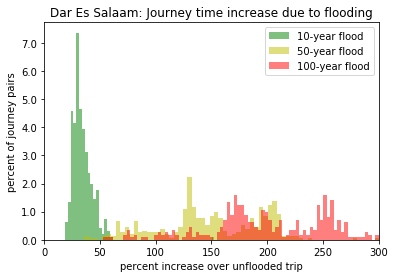

In [273]:
f,ax = plt.subplots(figsize=[6,4])

cols_to_show=['diff_10','diff_50','diff_100']
cols = ['g','y','r']

for n, column in enumerate(mean_times_by_firm[cols_to_show]):
    plt.hist(mean_times_by_firm[column],alpha=0.5,color=cols[n],bins=100,density = True)
    
ax.set_title('Dar Es Salaam: Journey time increase due to flooding')
plt.legend(cols_to_show)
plt.legend(['10-year flood','50-year flood','100-year flood'])
plt.xlim(0,300)

ax.set(xlabel="percent increase over unflooded trip", ylabel='percent of journey pairs');

ticks = ax.get_yticks() * 100
ticks = [round(n,1) for n in (list(ticks))]
ax.set_yticklabels(ticks);

In [263]:
len(mean_times_by_firm['diff_100'][mean_times_by_firm['diff_100'] > 250] ) / mean_times_by_firm.shape[0] * 100

23.036649214659686

In [281]:
(mean_times_by_firm['baseline_mean'][mean_times_by_firm['baseline_mean'] < 60 * 30].count() / 
 mean_times_by_firm.shape[0] * 100)

94.76439790575915

In [274]:
f.savefig('journey_time_increase_Dar.png')

In [ ]:
f,ax = plt.subplots(figsize=[6,4])

cols_to_show=['diff_10','diff_50','diff_100']
cols = ['g','y','r']

for n, column in enumerate(mean_times_by_firm[cols_to_show]):
    sns.kde_plot(mean_times_by_firm[column],alpha=0.5,color=cols[n],bins=100)
    
ax.set_title('Journey time increase due to flooding')
plt.legend(cols_to_show)
plt.legend(['10-year flood','50-year flood','100-year flood'])
plt.xlim(0,225)

ax.set(xlabel="percent increase over unflooded trip", ylabel='percent of journey pairs');

ticks = ax.get_yticks()*100
ticks = [round(n,1) for n in (list(ticks))]
ax.set_yticklabels(ticks);

In [211]:
n_firms = mean_times_by_firm.shape[0]

sum(mean_times_by_firm.diff_50 < 100)


72

In [250]:
return_period = 'diff_50'

threshold1 = 50
threshold2 = 100
threshold3 = 150
threshold4 = 200


print("Number of firms:")
print("Travel times increase up to {}%: {:.1f}".format(threshold1, sum((mean_times_by_firm[return_period] > 0) & 
                                                    (mean_times_by_firm[return_period] < threshold1))/ n_firms * 100))
print("Travel times increase up to {}%: {:.1f}".format(threshold2, sum((mean_times_by_firm[return_period] > threshold1) & 
                                                    (mean_times_by_firm[return_period] < threshold2))/ n_firms * 100))
print("Travel times increase up to {}%: {:.1f}".format(threshold3, sum((mean_times_by_firm[return_period] > threshold2) & 
                                                    (mean_times_by_firm[return_period] < threshold3))/ n_firms * 100))
print("Travel times increase up to {}%: {:.1f}".format(threshold4, sum((mean_times_by_firm[return_period] > threshold3) & 
                                                    (mean_times_by_firm[return_period] < threshold4))/ n_firms * 100))

print("Travel times increase more than {}%: {:.1f}".format(threshold4, sum((mean_times_by_firm[return_period] > threshold3) & 
                                                    (mean_times_by_firm[return_period] > threshold4))/n_firms * 100))

Number of firms:
Travel times increase up to 50%: 1.0
Travel times increase up to 100%: 15.2
Travel times increase up to 150%: 34.3
Travel times increase up to 200%: 29.6
Travel times increase more than 200%: 17.3


In [213]:
mean_times_by_firm.to_csv('data/mean_times_by_firm.csv')

In [214]:
return_period = 'diff_50'

print("Percent of firms:")
print("Travel times increase up to {}%: {:.1f}".format(threshold1, sum((mean_times_by_firm[return_period] > 0) & 
                                                    (mean_times_by_firm[return_period] < threshold1))/ n_firms * 100))
print("Travel times increase up to {}%: {:.1f}".format(threshold2, sum((mean_times_by_firm[return_period] > threshold1) & 
                                                    (mean_times_by_firm[return_period] < threshold2))/ n_firms * 100))
print("Travel times increase up to 75%: {:.1f}".format(sum((mean_times_by_firm[return_period] > 50) & 
                                                    (mean_times_by_firm[return_period] < 75))/ n_firms * 100))
print("Travel times increase up to {}%: {:.1f}".format(threshold3, sum((mean_times_by_firm[return_period] > 75) & 
                                                    (mean_times_by_firm[return_period] < 100))/ n_firms * 100))
print("Travel times increase up to {}%: {:.1f}".format(threshold3, sum((mean_times_by_firm[return_period] > 75) & 
                                                    (mean_times_by_firm[return_period] < 100))/ n_firms * 100))
print("Travel times increase more than {}%: {:.1f}".format(threshold3, sum(mean_times_by_firm[return_period] > threshold3)/ n_firms * 100))

Percent of firms:
Travel times increase up to 25%: 0.0
Travel times increase up to 50%: 1.0
Travel times increase up to 75%: 7.1
Travel times increase up to 100%: 8.1
Travel times increase more than 100%: 81.2


In [215]:
mean_times_by_firm['diff_100'][mean_times_by_firm['diff_100']<0] = 0

In [216]:
mean_times_by_firm['diff_50'].describe()

count    382.000000
mean     142.828521
std       60.698122
min     -100.000000
25%      122.415783
50%      144.930204
75%      192.364902
max      300.398145
Name: diff_50, dtype: float64

In [217]:
pd.DataFrame(data={'Up to 25% increase':sum(mean_times_by_firm.diff_10 < 25),
              'Travel times increase 25% to 50%':sum((mean_times_by_firm.diff_10 > 25) & (mean_times_by_firm.diff_10 < 50)),
              'Travel times increase 50% to 75%':sum((mean_times_by_firm.diff_10 > 50) & (mean_times_by_firm.diff_10 < 75)),
              'Up to 100% increase':sum((mean_times_by_firm.diff_10 > 75) & (mean_times_by_firm.diff_10 < 100)),
               'More than 100% increase':sum((mean_times_by_firm.diff_10 > 100) & (mean_times_by_firm.diff_10 < 400)),
                  }, index=['Travel time change by number firms']).T

,Travel time change by number firms
Up to 25% increase,42
Travel times increase 25% to 50%,323
Travel times increase 50% to 75%,16
Up to 100% increase,0
More than 100% increase,1


In [218]:
pd.DataFrame(data={'Up to 25% increase':sum(mean_times_by_firm.diff_10 < 25) / n_firms * 100,
              'Travel times increase 25% to 50%':sum((mean_times_by_firm.diff_10 > 25) & (mean_times_by_firm.diff_10 < 50)) / n_firms * 100,
              'Travel times increase 50% to 75%':sum((mean_times_by_firm.diff_10 > 50) & (mean_times_by_firm.diff_10 < 75)) / n_firms * 100,
              'Up to 100% increase':sum((mean_times_by_firm.diff_10 > 75) & (mean_times_by_firm.diff_10 < 10)) / n_firms * 100,
               'More than 100% increase':sum((mean_times_by_firm.diff_10 > 100) & (mean_times_by_firm.diff_10 < 400)) / n_firms * 100,
                  }, index=['Travel time change by percent firms']).T

,Travel time change by percent firms
Up to 25% increase,10.994764
Travel times increase 25% to 50%,84.554974
Travel times increase 50% to 75%,4.188482
Up to 100% increase,0.000000
More than 100% increase,0.261780


#### 10. Travel times grid to hospitals

In [219]:
grid_clipped = gpd.sjoin(grid,boundary_GDF,how='inner')

/anaconda3/envs/geo5/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


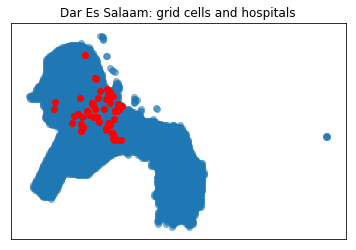

In [222]:
ax = boundary_GDF.plot(alpha = 0.1, figsize=[6,6])
#show(raster, ax = ax)

grid_clipped.plot(ax=ax,alpha=0.5)
POIs_health.plot(ax=ax,color='r')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.title('Dar Es Salaam: grid cells and hospitals');

In [221]:
baseline_OD_hosp = gn.calculate_OD(G3, list(grid_clipped.NN), list(POIs_health.NN), fail_value, weight='time')

KeyboardInterrupt: 

In [ ]:
flood_OD_hosp_access_10yr = gn.calculate_OD(G_flood10, list(grid_clipped.NN), list(POIs_health.NN), fail_value, weight='time')
flood_OD_hosp_access_50yr = gn.calculate_OD(G_flood50, list(grid_clipped.NN), list(POIs_health.NN), fail_value, weight='time')
flood_OD_hosp_access_100yr = gn.calculate_OD(G_flood100, list(grid_clipped.NN), list(POIs_health.NN), fail_value, weight='time')

In [ ]:
flood_OD_hosp_access_10yr[flood_OD_hosp_access_10yr > 10000] = np.nan
flood_OD_hosp_access_50yr[flood_OD_hosp_access_50yr > 10000] = np.nan
flood_OD_hosp_access_100yr[flood_OD_hosp_access_100yr > 10000] = np.nan

In [ ]:
baseline_df_hosp = pd.DataFrame(baseline_OD_hosp/60)
flood_df_hosp_10 = pd.DataFrame(flood_OD_hosp_access_10yr/60)
flood_df_hosp_50 = pd.DataFrame(flood_OD_hosp_access_50yr/60)
flood_df_hosp_100 = pd.DataFrame(flood_OD_hosp_access_100yr/60)

In [ ]:
time_to_nearest_hospital = pd.DataFrame({"Baseline":baseline_df_hosp.min(axis = 1),
              "Flood_10":flood_df_hosp_10.min(axis=1),
              "Flood_50":flood_df_hosp_50.min(axis=1),
              "Flood_100":flood_df_hosp_100.min(axis=1)})

In [ ]:
f,ax = plt.subplots(figsize=[9,6])
cols = ['b','g','y','r']

for n, column in enumerate(time_to_nearest_hospital.columns):
    sns.kdeplot(time_to_nearest_hospital[column],shade=True,color=cols[n])

ax.set_title('Travel times to nearest hospital')
plt.legend(['No flood','10-year flood','50-year flood','100-year flood'])
#ax.set_yticklabels([])
ax.set(xlabel="time", ylabel='frequency')

ticks = ax.get_yticks()*100
ticks = [round(n,1) for n in (list(ticks))]
ax.set_yticklabels(ticks);

In [ ]:
time_to_hospital_mean = pd.DataFrame({"Baseline":baseline_df_hosp.mean(axis = 1),
              "Flood_10":flood_df_hosp_10.mean(axis=1),
              "Flood_50":flood_df_hosp_50.mean(axis=1),
              "Flood_100":flood_df_hosp_100.mean(axis=1)})

In [ ]:
f,ax = plt.subplots(figsize=[6,4])
cols = ['b','g','r']
cols_to_show = ['Baseline','Flood_10','Flood_50']

for n, column in enumerate(cols_to_show):
    sns.kdeplot(time_to_hospital_mean[column],shade=True,color=cols[n])

ax.set_title('Mean travel times to hospitals')
plt.legend(['No flood','10-year flood','50-year flood'])
plt.xlim(0)
#ax.set_yticklabels([])
ax.set(xlabel="minutes", ylabel='percent of city locations')

ticks = ax.get_yticks()*100
ticks = [round(n,1) for n in (list(ticks))]
plt.axvline(x=30, color='grey', linestyle='dotted', linewidth = 3)
ax.set_yticklabels(ticks);

In [ ]:
time_to_hospital_mean.Flood_50.isnull().sum() / time_to_hospital_mean.shape[0] * 100

In [ ]:
time_to_hospital_mean.columns

In [ ]:
for column in time_to_hospital_mean.columns:
    print("Mean time to hospital ({}): {:.1f}".format(column, time_to_hospital_mean[column].mean()))

In [ ]:
def percent_change(changed, original):
    return (changed - original)/original * 100

mean_times_by_location = pd.DataFrame()
mean_times_by_location['diff_10'] = percent_change(time_to_hospital_mean.Flood_10, time_to_hospital_mean.Baseline)
mean_times_by_location['diff_50'] = percent_change(time_to_hospital_mean.Flood_50, time_to_hospital_mean.Baseline)
mean_times_by_location['diff_100'] = percent_change(time_to_hospital_mean.Flood_100, time_to_hospital_mean.Baseline)

In [ ]:
grid_clipped.shape

In [ ]:
print("Baseline - Number of city locations for which travel time to hospital exceeds 30 minutes: {}".format(
      time_to_hospital_mean.Baseline[time_to_hospital_mean.Baseline > 30].count()))

print("Percent of city locations for which travel time to hospital  exceeds 30 minutes: {:.1f}".format(
      time_to_hospital_mean.Baseline[time_to_hospital_mean.Baseline > 30].count()
       / time_to_hospital_mean.Baseline.shape[0] * 100))

In [ ]:
print("10 year flood - Number of city locations for which travel time to hospital exceeds 30 minutes: {}".format(
      time_to_hospital_mean.Flood_10[time_to_hospital_mean.Flood_10 > 30].count()))

print("Percent of city locations for which travel time to hospital  exceeds 30 minutes: {:.1f}".format(
      time_to_hospital_mean.Flood_10[time_to_hospital_mean.Flood_10 > 30].count()
       / time_to_hospital_mean.Flood_10.shape[0] * 100))

In [ ]:
print("50 year flood - Number of city locations for which travel time to hospital exceeds 30 minutes: {}".format(
      time_to_hospital_mean.Flood_50[time_to_hospital_mean.Flood_50 > 30].count()))

print("Percent of city locations for which travel time to hospital  exceeds 30 minutes: {:.1f}".format(
      time_to_hospital_mean.Flood_50[time_to_hospital_mean.Flood_50 > 30].count()
       / time_to_hospital_mean.Flood_50.shape[0] * 100))

In [417]:
print("Number of city locations for which travel time to hospital exceeds 30 minutes: {}".format(
      mean_times_by_location.diff_50[mean_times_by_location.diff_50 > 100].count()))

print("Percent of city locations for which travel time to hospital doubles or more: {:.1f}".format(
      mean_times_by_location.diff_50[mean_times_by_location.diff_50 > 100].count()
       / mean_times_by_location.shape[0] * 100))

Number of city locations for which travel time to hospital exceeds 30 minutes: 135
Percent of city locations for which travel time to hospital doubles or more: 17.2


In [355]:
135/785

0.17197452229299362

In [171]:
change_df = pd.DataFrame({"mean times":[baseline_mean, flood_10_mean, flood_100_mean]},index=
                        ['no flood','10-year flood','100-year flood'])

In [172]:
change_df['percent difference'] = (change_df['mean times'] - change_df['mean times'][0]) / change_df['mean times'][0] * 100
change_df

,mean times,percent difference
no flood,10.437851,0.000000
10-year flood,16.056173,53.826420
100-year flood,17.624052,68.847508
